# Indeed Business Analyst Data Scraping and Analysis

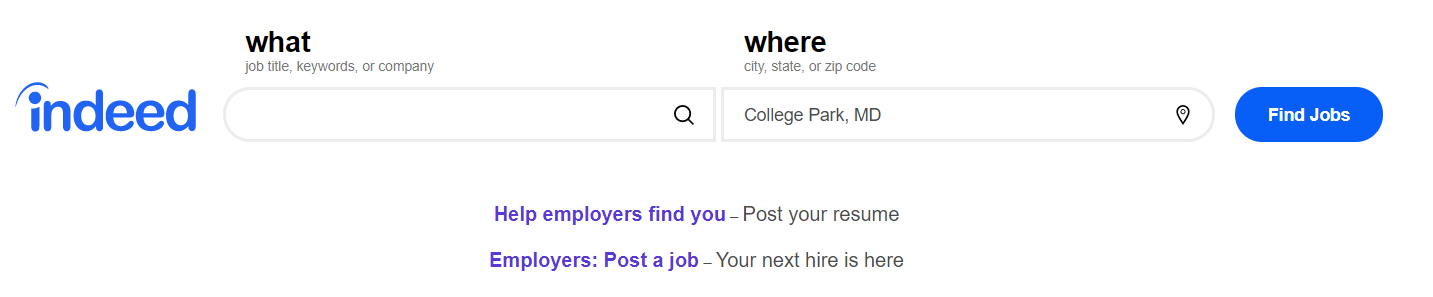

In [2]:
from IPython.display import Image
Image(filename='indeed_pic.png',width=800,height=800)

- Scraping data from Indeed.com
- Cleaning data
- Parsing and visulizing data
- Text mining and nature language processing

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import time
import glob  
import numpy as np
from numpy import nan

Necessary job information we scraped from indeed website:
- **Job Title:**    the listed title of the job;
- **Job Location:** the location of the job;
- **Job Summary:**  an general description of the job;
- **Company Name:** the job belongs to which company;
- **Salary:**       salary of the job if it's public to see.

In [4]:
max_results_per_city = 200
column_name = ['job_title','company_name','location','summary','salary']

**Step 1: Scrape the raw data into corresponding list**

In [5]:
# Initialize the 5 new list, and we will put the scraped data into these list correspondingly;

jobTitle = []
companies = []
location = []
salary = []
summary = []
for start in range(0,max_results_per_city,10): 
    URL = 'https://www.indeed.com/jobs?q=business+analyst&l='+'NY'+'&start='+str(start)#"NY" in the URL means we are now processing data in NY
    page = requests.get(URL)
    time.sleep(1)
    soup = BeautifulSoup(page.text,'lxml')
    for div in soup.find_all(name='div', attrs={'class':'row'}):
        # extract all the job titles
        for a in div.find_all(name='a', attrs={'data-tn-element':'jobTitle'}):
            jobTitle.append(a['title'])
        # extract all the company names
        company = div.find_all(name='span',attrs={'class':'company'})
        if len(company) > 0:
            for b in company:
                companies.append(b.text.strip())
        else:
            sec_try = div.find_all(name='span',attrs={'class':'reslut-link-source'})
            for span in sec_try:
                companies.append(span.text.strip())
        # extract location information of job postings
        c = soup.findAll('span',attrs = {'class':'location'})
        for span in c:
            location.append(span.text)
        # extract brief job description on the result page
        d = soup.findAll('span', attrs={'class': 'summary'})
        for span in d:
            summary.append(span.text.strip())
        # extract salary when a job posting has this kind of information otherwise replace it with np.nan
        for div in soup.find_all(name='div', attrs={'class':'row'}):   
            if len(div.find_all(name='span',attrs={'class':'no-wrap'}))>0:
                spans = div.find_all(name='span',attrs={'class':'no-wrap'})
                for span in spans:
                    salary.append(span.text.strip())
            else:
                salary.append(np.nan)  

**Step 2: Cast the List above into DataFrame**

In [6]:
# This is an example of NY, we will do the same precess for other states
ny_df = pd.DataFrame(list(zip(jobTitle,companies,location,summary,salary)),columns=column_name)

In [7]:
# Let's have a look at what it looks like:
ny_df.head(5)

,job_title,company_name,location,summary,salary
0,Junior Business Analyst,RSG Media Systems LLC.,"New York, NY",Business Analyst – Job Description*. The busin...,NaN
1,M&A and Business Development Analyst - Intern,"The Smilist Management, Inc.","Great Neck, NY",The Smilist M&A and Business Development Analy...,NaN
2,Murex Business Analyst,Ana-Data Consulting,"New York, NY",Work with Business Stakeholders to gather requ...,NaN
3,Axiom Technical Business Analysts(Need Locals ...,Sovereigntec,"New York, NY",Translate client’s business needs into detaile...,$50 - $60 an hour
4,Business Analyst,Yantra Services USA Inc,"New York, NY",Contract to Hire ROLE only! Contract will be o...,$55 - $58 an hour


**Step 3: Convert DataFrame into csv files**

In [12]:
ny_df.to_csv('ny.csv')

**Problem you may face here:**

There's nothing wrong about last step if you are **Windows** user; However, if you are **Mac** user, you have to write as below to eliminate some format problems:
`ny_df.to_csv('ny.csv', encoding='utf-8')` 

**Step 4: Merge every single csv file about each state to a final csv file: 'project_total.csv'**

In [13]:
# Since we have 10 states, we have to merge these 10 into a final one file.
path =r'/Users/maoma/Desktop/states' 
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_10 = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_10.append(df)
project = pd.concat(list_10)
project.to_csv('project_total.csv')

## 2.2 Cleaning data

Primary packagies we used here:
- **re** 
- **pandas**
- **numpy**

In [3]:
import pandas as pd
import re
import numpy as np
from pandas import Series, DataFrame
import warnings
warnings.filterwarnings("ignore")

In [15]:
df=pd.read_csv('project_total.csv',index_col=None)
df.head()

,Unnamed: 0,Unnamed: 0.1,job_title,company_name,location,summary,salary
0,0,0,IT Business Systems Analyst,Hydranautics A Nitto Group Company,"Oceanside, CA 92058","Strong knowledge of business operations, objec...","$81,000 - $91,500 a year"
1,1,1,Product Analyst,Wag!,"Los Angeles, CA",Is looking for an enthusiastic Product Analyst...,NaN
2,2,2,IT Business Analyst,"Tireco, Inc","Gardena, CA 90248",Business Analyst (BA) who will be responsible ...,"$60,000 - $80,000 a year"
3,3,3,Business Analyst,Micro Focus,"Sunnyvale, CA",The Business Analyst. The Business Analyst is ...,NaN
4,4,4,Business Analyst,Thermo Fisher Scientific,California,The Business Analyst is a member of the Custom...,NaN


**Step 1: Choose terget columns**

Sometimes a system-generated column showing as a new index column appears in the merged csv file, we can choose the columns we want:

In [16]:
df1=df[['job_title','company_name','location','salary']] 
df1.head()

,job_title,company_name,location,salary
0,IT Business Systems Analyst,Hydranautics A Nitto Group Company,"Oceanside, CA 92058","$81,000 - $91,500 a year"
1,Product Analyst,Wag!,"Los Angeles, CA",NaN
2,IT Business Analyst,"Tireco, Inc","Gardena, CA 90248","$60,000 - $80,000 a year"
3,Business Analyst,Micro Focus,"Sunnyvale, CA",NaN
4,Business Analyst,Thermo Fisher Scientific,California,NaN


**Step 2: Reset index**

Since the index now is from 0, if you are uncomfortable with that,you can reset the index from 1

In [17]:
df1.index = range(1,len(df1) + 1)
df1.head()

,job_title,company_name,location,salary
1,IT Business Systems Analyst,Hydranautics A Nitto Group Company,"Oceanside, CA 92058","$81,000 - $91,500 a year"
2,Product Analyst,Wag!,"Los Angeles, CA",NaN
3,IT Business Analyst,"Tireco, Inc","Gardena, CA 90248","$60,000 - $80,000 a year"
4,Business Analyst,Micro Focus,"Sunnyvale, CA",NaN
5,Business Analyst,Thermo Fisher Scientific,California,NaN


**Step 3: Unify the state name**

Since the state here sometimes are called "NY", but sometomes are called "New York State", we decide to unify them into "NY".
And similar situations happen on California, Florida etc., we have to do the same work.

In [18]:
df1['location']=df1['location'].replace('New York State','NY')
df1['location']=df1['location'].replace('California','CA')
df1['location']=df1['location'].replace('Florida','FL')
df1['location']=df1['location'].replace('New Jersey','NJ')  
df1['location']=df1['location'].replace('Pennslyvania','PA')
df1['location']=df1['location'].replace('Texas','TX')
df1['location']=df1['location'].replace('Virginia','VA')

**Step 4: Split location into two clolumns: city and state**

New column 'city' follow the patterns as below:

In [19]:
df1['city']=df1['location'].str.extract('(\w*\s?\w*\,)',expand=False)

New column 'state' follow the patterns as below:

In [20]:
df1['state']=df1['location'].str.extract('([A-Z]{2})',expand=False)

Then we generate a new DataFrame without 'location':

In [21]:
df1=df1[['job_title','company_name','salary','city','state']]
df1.head()

,job_title,company_name,salary,city,state
1,IT Business Systems Analyst,Hydranautics A Nitto Group Company,"$81,000 - $91,500 a year","Oceanside,",CA
2,Product Analyst,Wag!,NaN,"Los Angeles,",CA
3,IT Business Analyst,"Tireco, Inc","$60,000 - $80,000 a year","Gardena,",CA
4,Business Analyst,Micro Focus,NaN,"Sunnyvale,",CA
5,Business Analyst,Thermo Fisher Scientific,NaN,NaN,CA


But there's still a comma in the "city" column, we have to replace it with space:

In [22]:
df1['city']=df1['city'].str.replace('\,','')#delete comma in the 'city' column

At this time, if there's no data in "city" or "salary" column, it would appears as NaN:

In [23]:
df1.head(10)

,job_title,company_name,salary,city,state
1,IT Business Systems Analyst,Hydranautics A Nitto Group Company,"$81,000 - $91,500 a year",Oceanside,CA
2,Product Analyst,Wag!,NaN,Los Angeles,CA
3,IT Business Analyst,"Tireco, Inc","$60,000 - $80,000 a year",Gardena,CA
4,Business Analyst,Micro Focus,NaN,Sunnyvale,CA
5,Business Analyst,Thermo Fisher Scientific,NaN,NaN,CA
6,Business Analyst - 8126606,Ursus Incorporated,NaN,Mountain View,CA
7,AppleCare Business Analyst,Apple,NaN,Clara Valley,CA
8,Business Analyst,Stanford University,NaN,NaN,CA
9,Business Analyst,Capgemini,NaN,NaN,CA
10,Business Analyst,Cisco,NaN,San Jose,CA


**Step 4: Missing data processing**

Let's see what the distribution of the "salary" column is:

In [26]:
df1['salary'].value_counts().head()

$85,000                      2413
$70,000 - $100,000 a year      64
$55,680 - $100,600 a year      39
$50 - $55 an hour              33
$60,000 - $80,000 a year       20
Name: salary, dtype: int64

In [25]:
df1['salary']=df1['salary'].fillna("$85,000")

## 2.3 Parsing and visulizing data

### 2.3.1 Descriptive statistics of salary

Before that, we have to eliminate the characters in salary such as "in a year". Therefore, we can replace the non-numerical characters with spaces.

In [7]:
L1=df1['salary']
L2=[]
for i in L1:
    i = re.sub('[^0-9^-]','',str(i)) #replace all non-numeric and non-dash characters with space
    L2.append(i)

And then, we definte a function to help us find different formats in the salary column:

In [8]:
def unique(list1): 
    unique_list = []
    for x in list1:
        if x not in unique_list:
            unique_list.append(x)
    for x in unique_list:
        print (x)

In [9]:
unique(L2)

85000
50-60
55-58
85000-95000


Use avergae to substitude a salary range:

In [10]:
L3=[]
for i in L2:
    if i=='85000-95000':
        i=(85000+95000)/2
    elif i=='55-58':
        i=(55+58)/2
    elif i=='50-60':
        i=(50+60)/2
    else:
        pass    
    L3.append(i)

Cast into integer:

In [11]:
L4=[]
for i in L3:
    i=int(i)
    L4.append(i)

We need to find the integer which use unit of 'an hour' or 'a year' (obviously, small numbers are ended with hourly salary); And then convert the hourly wage to annual salary:

In [13]:
L5=[]
for i in L4:
    if i<=56:
        i=i*34.4*52 
    else:
        pass
    i=int(i)
    L5.append(i)

Convert the list L5 to Series:

In [14]:
SER1=pd.Series(L5)

In [15]:
SER1.describe()

count       311.000000
mean      86402.662379
std        4029.845477
min       85000.000000
25%       85000.000000
50%       85000.000000
75%       85000.000000
max      100172.000000
dtype: float64

### 2.3.2 Visualizition of salary

In [49]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


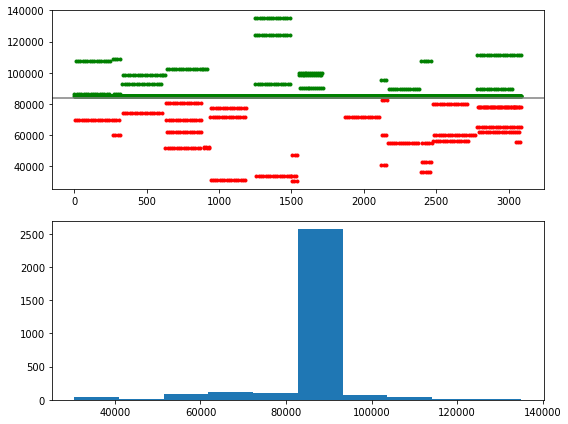

In [50]:
# Scatter plot with color encoding
fig, ax = plt.subplots(2, 1, sharex=False, figsize=(8,6))
negative = SER1 < 86402
ax[0].plot(SER1[negative],'r.')
ax[0].plot(SER1[~negative],'g.')
ax[0].axhline(86402, c='0.5', alpha=1)

ax[1].hist(SER1)

fig.tight_layout()

### 2.3.3 Visualizition of job distribution among cities (geo maps)

Basic idea in this part is to plot the distribution of jobs on the US maps; **the more jobs are located in a state, the area of the circle is larger**. Therefore, the primary packagies we used here:
- **Basemap**
- **urllib**
- **geopy** 
- **math**

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
import math

In [37]:
df2=pd.read_csv('project_total_clean.csv',index_col=None)
df2.head()

,Unnamed: 0,job_title,company_name,summary,salary,city,state
0,1,Business Analyst,CHMB,Business Data Analyst role provides immediate ...,"$50,000 - $60,000 a year",Novato,CA
1,2,Business Systems Analyst,AMERICAN ADVISORS GROUP,Business Systems Analyst*. American Advisors G...,"$80,000 - $102,000 a year (Indeed est.)",Orange,CA
2,3,Product Information Analyst,"PriceSmart, Inc.",Product Information Analyst. Prefer Computer S...,Nothing_found,San Diego,CA
3,4,Business Analyst,San Diego County Credit Union,Two years’ experience within an IT environment...,Nothing_found,San Diego,CA
4,5,Business Analyst,Thermo Fisher Scientific,The Business Analyst is a member of the Custom...,Nothing_found,NaN,CA


In [38]:
group_state = df2['city'].groupby(df2['state']).count()
group_state

state
CA    252
FL    272
MD    306
MN    293
NJ    289
NY    279
PA    288
TX    272
VA    252
WA    320
Name: city, dtype: int64

From the output above, the results are too close which is not suitable for us to distinguish the plot areas, therefore, we decide to choose the city which has the highest jobs to represent that state:

In [39]:
df2['city'].value_counts().head(20)

New York        161
Minneapolis     114
Columbia         93
Jersey City      92
Seattle          84
Bethesda         72
Alexandria       72
Bellevue         68
Baltimore        61
Orlando          60
Boca Raton       60
Philadelphia     59
Arlington        56
Eagan            55
Saint Paul       46
Plano            44
Austin           44
San Diego        40
Camas            40
Renton           36
Name: city, dtype: int64

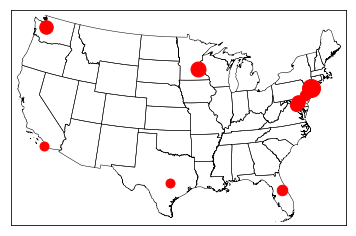

In [40]:
cities = [["Seattle",84],
          ["Arlington,VA",72],
          ["Austin",44],
          ["San Diego",40],
          ["Philadelphia",60],
          ["New York",161],
          ["Baltimore",93],
          ["Minneapolis",114],
          ["Jersey City",92],
          ["Orlando",60]]
scale = 3

map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95)

map.readshapefile('cb_2017_us_state_500k', name='state', drawbounds=True)
# Get the location of each city and plot it
geolocator = Nominatim()
for (city,count) in cities:
    loc = geolocator.geocode(city)
    x, y = map(loc.longitude, loc.latitude)
    map.plot(x,y,marker='.',color='Red',markersize=int(math.sqrt(count))*scale)
plt.show()

# 3. Exploratory Analysis of Job Description

Tasks to be done in this part involves natural language processing, therefore primary packagies we used here:
- **beautifulSoup**
- **urllib**
- **requests, re** 
- **pandas**
- **seaborn**
- **nltk**

In [4]:
%pylab inline
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from time import sleep
from urllib.request import urlopen
from bs4 import BeautifulSoup

Populating the interactive namespace from numpy and matplotlib


In [30]:
# Get text for a specific job 
def get_text(url):
    html = urlopen(url)
    site = html.read()
    soup = BeautifulSoup(site, 'html.parser')
    for i in soup.find_all("script"):
        i.decompose()
    for i in soup.find_all("style"):
        i.decompose()
    for i in soup.find_all("noscript"):
        i.decompose()
    for i in soup.find_all("div"):
        i.decompose()
    for i in soup.find_all("meta"):
        i.decompose()
    text = soup.get_text()
    lines = (line.strip() for line in text.splitlines()) 
    lines = [l for l in lines if l != '']
    cleaned = ' '.join(lines)
    return(cleaned)

In [31]:
# Get links for all job posts in a page
def get_links(url):
    html = urlopen(url)
    site = html.read()
    soup = BeautifulSoup(site, 'html.parser')
    results = soup.find(id = 'resultsCol')
    page_urls = [link.get('href') for link in results.find_all('a')]
    page_urls = [link for link in page_urls if '/rc/' in str(link)]
    ids = []#array to store job ids
    for link in page_urls:
        start = link.find('jk=') + 3#finding locations in the string to start and stop
        end = link.find('&fccid=')
        ids.append(link[start:end])#appending id to the array
    return(ids)

In [40]:
# define a function to loop and scrape job descriptions
def get_job_descriptions(search_url):
    html = urlopen(search_url)
    site = html.read()
    soup = BeautifulSoup(site, 'html.parser')
    results = soup.find(id = 'resultsCol')
    divs = results.find_all('div')
    for x in divs:
        if x.get('id') == 'searchCount':#grabbing the id tag for the search count
            count_string = x
            count_string = count_string.get_text()
            count = count_string.split(' ')[-2]#spitting the string by white spaces and keeping only the last value
            count = count.replace(',', '')#removing the punctuation
            count = int(count)
    
    print("Getting job ids...")
    i = 0
    job_ids = []
    while i < count:
        url = search_url + '&start=' + str(i)#creating custom search url for the correct page of results
        job_ids = job_ids + get_links(url)
        sleep(1)
        i = i + 10
    print("Finished pulling job ids. Getting descriptions...")
    
    descriptions = []
    
    #creating a counter to keep track of progress
    iteration_counter = 0
    for id in job_ids:
        #Printing out progress if we are on a tenth job id
        if iteration_counter % 10 == 0:
            print("Grabbing job " + str(iteration_counter))
        iteration_counter = iteration_counter + 1
        url = "https://www.indeed.com/viewjob?jk=" + str(id)
        descriptions.append(get_text(url))
        sleep(1)
    
    return(descriptions)

In [33]:
results = get_job_descriptions('https://www.indeed.com/jobs?q=business+analyst+entry+level+%2420000&l=MD')

Getting job ids...
Finished pulling job ids. Getting descriptions...
Grabbing job 0
Grabbing job 10
Grabbing job 20
Grabbing job 30
Grabbing job 40
Grabbing job 50
Grabbing job 60
Grabbing job 70
Grabbing job 80
Grabbing job 90


In [34]:
#saving results to a text file to reopen later if desired
f = open("job_descriptions.txt", "w")
for i in results:
    f.write(str(i)+'\n')
    
f.close()

## 3.1 Business Analyst of Different Level Explore

### 3.1.1 One specific job description analysis

In [5]:
ent_data = pd.read_csv('md_ba_entrylevel.txt',delimiter="\t", header=None,names=["job_description"])
ent_data.head(5)

,job_description
0,Associate Business Analyst (Salesforce trainin...
1,Junior Business Analyst job - Appsential LLC -...
2,Junior Business Analyst job - Centeva - Rockvi...
3,"Junior Business Analyst job - DRT Strategies, ..."
4,Junior Business Analyst (position can work rem...


**Step 1: Choose appropiate stopwords**

In [6]:
# Customize stopwords (such as 'job','company','analyst','md') for extracting useful info for future analysis
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['job','company','analyst','md','city','title','indeedcom','keywords','state','zip','we’re',"you'll",
                'business','experience','management','system']
stopwords.extend(newStopWords)

**Step 2: Standardization**

In [7]:
def standardize_description(index, des='job_description'):
    # Extract report from player data frame
    s = ent_data.at[index, des]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,().|!:#&-/]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

**Step 3: Visualizition of the most common words**

In [11]:
# Counter from Collections Module
words = standardize_description(0)
c = Counter(words)

In [12]:
#Visualize frequency of most common words
#plt.figure(figsize=(12,4))
fd = FreqDist(Text(words))

In [13]:
# Collocations
Text(words).collocations()

salesforcecom httpsalesforcecom; program designed; cloud technology


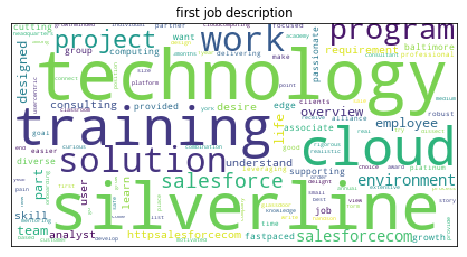

In [14]:
# Word Cloud
wc = WordCloud(background_color='white').generate(' '.join(words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('first job description');

### 3.1.2 Analysis of all documents of entry level 

In [24]:
# Process and assemble into corpus
descriptions = []
for idx in ent_data.index:
    if type(ent_data.at[idx, 'job_description']) == str:
        descriptions.append(standardize_description(idx))
len(descriptions)

97

In [25]:
# Define dictionary of job descriptions
D = Dictionary(descriptions)
print('Number of documents:', D.num_docs)
print('Number of words:', D.num_pos)
# Create corpus
corpus = [D.doc2bow(description) for description in descriptions]

Number of documents: 97
Number of words: 7107


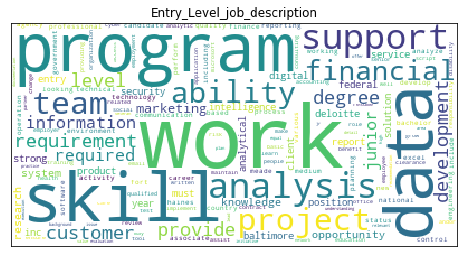

In [26]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count)
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('Entry_Level_job_description');

### 3.1.3  TFIDF of all documents of entry level 

In [34]:
# Create a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(corpus)

# Calculate the tfidf weights of specific document: tfidf_weights
inx= 0
tfidf_weights = tfidf[corpus[inx]]

# Sort the weights from highest to lowest: sorted_tfidf_weights
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)

# Print the top 10 weighted words
for term_id, weight in sorted_tfidf_weights[:10]:
    print(term_id, D.get(term_id), weight)

132 silverline 0.41673057696261356
143 technology 0.25267166204027736
24 cloud 0.235725831079475
130 salesforce 0.20836528848130678
131 salesforcecom 0.20836528848130678
148 training 0.16900754219868305
46 designed 0.13891019232087118
78 httpsalesforcecom 0.13891019232087118
136 solution 0.12691298863641567
56 environment 0.1136525429662052


In [35]:
# Initialize empty DataFrame
wdf = pd.DataFrame(index=range(len(tfidf.dfs)))

In [36]:
# Loop through documents in corpus
i = 0
for inx in ent_data.index:
    if type(ent_data.at[inx, 'job_description']) == str:
        wdf[ent_data.at[inx, 'job_description']] = pd.Series(dict(tfidf[corpus[i]]))
        i += 1
wdf.fillna(0, inplace=True)

In [37]:
# Define and fit KMeans cluster object
k = 3
cluster = KMeans(n_clusters=k)
cluster.fit(wdf.T)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
# Determine cluster sizes
cid = cluster.predict(wdf.T)
pd.Series(cid).value_counts().sort_index()

0    30
1    42
2    16
dtype: int64

In [39]:
# Assemble cluster centers into dataframe
ccdf = pd.DataFrame(cluster.cluster_centers_)
ccdf.columns = [D.get(i) for i in ccdf.columns]
ccdf.head()

,1,1year,2018,3months,ability,academy,achieve,activity,alliance,among,...,lan,bowie,delivery,efederaladvisory,pdmcyber,riskproject,sr,juniormidsenior,mid,world’s
0,5.204170e-18,-3.252607e-19,-3.252607e-19,-3.252607e-19,0.000000,-3.252607e-19,0.000000,0.000000,-3.252607e-19,0.000000,...,1.872386e-02,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,3.469447e-18,-1.734723e-18,3.252607e-19,3.252607e-19,3.252607e-19
1,1.699952e-02,1.653693e-03,1.653693e-03,1.653693e-03,0.021731,1.653693e-03,0.002627,0.012491,1.653693e-03,0.003949,...,-2.602085e-18,4.336809e-18,4.336809e-18,4.336809e-18,4.336809e-18,4.336809e-18,1.138415e-03,1.341707e-03,1.341707e-03,1.341707e-03
2,0.000000e+00,2.168404e-19,2.168404e-19,2.168404e-19,0.004187,2.168404e-19,0.000000,0.000000,2.168404e-19,0.000000,...,2.602085e-18,2.558682e-02,2.558682e-02,2.558682e-02,2.558682e-02,2.558682e-02,2.170998e-02,0.000000e+00,0.000000e+00,0.000000e+00


In [40]:
# Report top N words for each cluster
N = 10
for i in ccdf.index:
    print('Cluster', i, '\n')
    sorted_weights = ccdf.loc[i].sort_values(ascending=False)
    print(sorted_weights.head(N), '\n')

Cluster 0 

hopkins       0.080197
john          0.075754
columbia      0.072684
junior        0.064475
baltimore     0.062973
spring        0.058004
university    0.056032
grant         0.052239
silver        0.049358
bethesda      0.042166
Name: 0, dtype: float64 

Cluster 1 

data         0.040034
level        0.034485
program      0.033170
financial    0.032277
entry        0.029835
rockville    0.028587
marketing    0.027962
bethesda     0.027342
skill        0.025588
project      0.025195
Name: 1, dtype: float64 

Cluster 2 

deloitte       0.181972
meade          0.178766
fort           0.178766
application    0.082434
cyber          0.071874
duluth         0.051809
abacus         0.051809
network        0.047510
security       0.046526
programmer     0.041321
Name: 2, dtype: float64 



### 3.1.4 Analysis of all documents of junior level

In [46]:
jun_data = pd.read_csv('md_ba_juniorlevel.txt',delimiter="\t", header=None,names=["job_description"])
jun_data.head(5)

,job_description
0,"Junior Business Analyst job - DRT Strategies, ..."
1,Junior Business Analyst job - Unissant - Silve...
2,Junior Business Analyst job - Appsential LLC -...
3,Business Analyst job - Thermo Fisher Scientifi...
4,"Data Analyst III job - Qlarant - Baltimore, MD..."


In [47]:
def standardize_description(index, des='job_description'):
    # Extract report from player data frame
    s = jun_data.at[index, des]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,().|!:#&-/]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [48]:
descriptions = []
for idx in jun_data.index:
    if type(jun_data.at[idx, 'job_description']) == str:
        descriptions.append(standardize_description(idx))

In [49]:
# Define dictionary of job descriptions
D = Dictionary(descriptions)
print('Number of documents:', D.num_docs)
print('Number of words:', D.num_pos)
# Create corpus
corpus = [D.doc2bow(description) for description in descriptions]

Number of documents: 145
Number of words: 15919


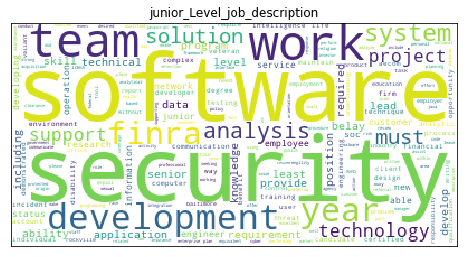

In [50]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count)
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('junior_Level_job_description');

### 3.1.5 Analysis of all documents of senior level

In [51]:
sen_data = pd.read_csv('md_ba_seniorlevel.txt',delimiter="\t", header=None,names=["job_description"])
sen_data.head(5)

,job_description
0,Business Systems Analyst job - Loginsoft Consu...
1,Sr Business Analyst/Trainer job - NewWave Tele...
2,Business Analyst II job - McCormick - Hunt Val...
3,Senior Finance Analyst - Business Performance ...
4,Sr. Business Analyst job - Sandy Spring Bank -...


In [52]:
def standardize_description(index, des='job_description'):
    # Extract report from player data frame
    s = sen_data.at[index, des]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,().|!:#&-/]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [53]:
descriptions = []
for idx in sen_data.index:
    if type(sen_data.at[idx, 'job_description']) == str:
        descriptions.append(standardize_description(idx))

In [54]:
# Define dictionary of job descriptions
D = Dictionary(descriptions)
print('Number of documents:', D.num_docs)
print('Number of words:', D.num_pos)
# Create corpus
corpus = [D.doc2bow(description) for description in descriptions]

Number of documents: 630
Number of words: 66062


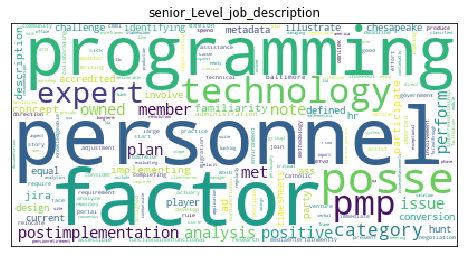

In [55]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count)
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('senior_Level_job_description');

### 3.1.6 Analysis of all documents of lead level

In [61]:
lea_data = pd.read_csv('md_ba_leadlevel.txt',delimiter="\t", header=None,names=["job_description"])
lea_data.head(5)

,job_description
0,Business Process Analyst job - McCormick - Hun...
1,Lead Business Analyst job - CareFirst BlueCros...
2,"Junior Business Analyst job - DRT Strategies, ..."
3,Business Systems Analyst job - Loginsoft Consu...
4,Sr Business Analyst/Trainer job - NewWave Tele...


In [62]:
def standardize_description(index, des='job_description'):
    # Extract report from player data frame
    s = lea_data.at[index, des]
    
    # Convert text to lower case
    s = s.lower()
    
    # Remove unnecessary punctuation
    s = re.sub('[,().|!:#&-/]', '', s)
    
    # Regular expression tokenization - Method 1
    words = regexp_tokenize(s, '[^. ]+')
    
    # Filter stop words from tokenized words
    words = [word for word in words if word not in stopwords]
    
    # Lemmatizataion
    lmtzr = WordNetLemmatizer()
    words = [lmtzr.lemmatize(word) for word in words]
    
    return words

In [63]:
descriptions = []
for idx in lea_data.index:
    if type(lea_data.at[idx, 'job_description']) == str:
        descriptions.append(standardize_description(idx))

In [64]:
# Define dictionary of job descriptions
D = Dictionary(descriptions)
print('Number of documents:', D.num_docs)
print('Number of words:', D.num_pos)
# Create corpus
corpus = [D.doc2bow(description) for description in descriptions]

Number of documents: 482
Number of words: 53842


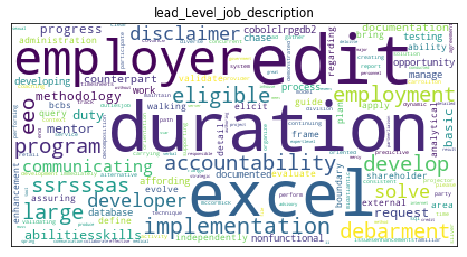

In [65]:
# Assemble all words with frequencies for Word Cloud
all_words = []
for word_id, word_count in word_counts:
    all_words.extend([D.get(word_id)] * word_count)
# Word Cloud
wc = WordCloud(background_color='white', collocations=False).generate(' '.join(all_words))
plt.figure(figsize=(8,8))
plt.xticks([])
plt.yticks([])
plt.imshow(wc)
plt.title('lead_Level_job_description');

## 3.2 Specific programming language count for each level position

In [66]:
import os
from collections import Counter
import glob

def word_frequency(fileobj, words):
    """Build a Counter of specified words in fileobj"""
    # initialise the counter to 0 for each word
    ct = Counter(dict((w, 0) for w in words))
    file_words = (word for line in fileobj for word in line.split())
    filtered_words = (word for word in file_words if word in words)
    return Counter(filtered_words)


def count_words_in_dir(dirpath, words, action=None):
    """For each .txt file in a dir, count the specified words"""
    for filepath in glob.iglob(os.path.join(dirpath, '*.txt')):
        with open(filepath) as f:
            ct = word_frequency(f, words)
            if action:
                action(filepath, ct)


def print_summary(filepath, ct):
    words = sorted(ct.keys())
    counts = [str(ct[k]) for k in words]
    print('{0}\n{1}\n{2}\n\n'.format(
        filepath,
        ', '.join(words),
        ', '.join(counts)))


words = set(['python', 'SQL', 'R','Excel'])
count_words_in_dir('./', words, action=print_summary)

./md_ba_juniorlevel.txt
Excel, SQL
5, 7


./md_ba_leadlevel.txt
Excel, SQL, python
3, 12, 4


./md_ba_seniorlevel.txt
Excel, R, SQL
24, 2, 19


./md_ba_entrylevel.txt
Excel
5


